In [ ]:
# imports
import pandas 
import numpy 
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from matplotlib import pyplot
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# load data
!curl -L -o table.csv "https://www.eia.gov/consumption/residential/data/2009/csv/recs2009_public.csv"
df = pandas.read_csv("table.csv")
df.describe()

In [ ]:
# fill missing values with 
df.fillna(0)
# drop DOEID column  
df = df.drop('DOEID', axis=1)
# replace "." string with 0 in NOCRCASH and NKRGALNC variables 
df['NOCRCASH'] = df['NOCRCASH'].replace(['.'],[float(0)])
df['NKRGALNC'] = df['NKRGALNC'].replace(['.'],[float(0)])
# convert strings too numeric in NOCRCASH and 'NKRGALNC' variables 
df['NOCRCASH'] = pandas.to_numeric(df['NOCRCASH'])
df['NKRGALNC'] = pandas.to_numeric(df['NKRGALNC'])
# encode categorial variables 
df['UR'] = df['UR'].replace(['NONE','R','U'],[0,1,2])
df['METROMICRO'] = df['METROMICRO'].replace(['NONE','MICRO','METRO'],[0, 1,2])
climate = list(set(df['IECC_Climate_Pub'].to_list()))
factors = [i for i in range(1,12)]
df['IECC_Climate_Pub'] = df['IECC_Climate_Pub'].replace(climate, factors)
# remove variables if more than 95% of them are 0 or -2
df = df.loc[:, (df==0).mean() < .95]
df = df.loc[:, (df==-2).mean() < .95]
# remove variables with a constant vaule
df = df[[col for col in df if not df[col].nunique()==1]]
# store KWH in a seprate dataframe before normalization
lables = df[['KWH']]
df = df.drop('KWH', axis=1)
# Min-Max normalization
scaler = MinMaxScaler()
headers = df.columns
scaled = scaler.fit_transform(df)
df_normalized = pandas.DataFrame(scaled)
df_normalized.columns = headers 
# add the KWH again at the end of the dataframe 
df = df_normalized.join(lables)

In [ ]:
# convert the dataframe to dataset array
dataset = df.values
# shuffle the dataset 
numpy.random.shuffle(dataset)
# split the dataset to 70% training set and 30% test set
train, test = numpy.split(dataset, [int(.7*len(dataset))])
X_train = train[:,0:-1]
Y_train = train[:,-1]
X_test = test[:,0:-1]
Y_test = test[:,-1]

In [ ]:
# build the model
model = Sequential()
model.add(Dense(30, activation="relu", input_dim=456))
model.add(Dense(20, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(1, activation="linear"))

# compile the model
model.compile(loss='mean_squared_error', optimizer=Adam(lr=1e-3, decay=1e-3/100))

# fit the model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=1000, batch_size=500, verbose=2)

In [ ]:
# calculate predictions
pred_test_set = model.predict(X_test)

# save predictions
numpy.savetxt("test_results.csv", pred_test_set, delimiter=",")

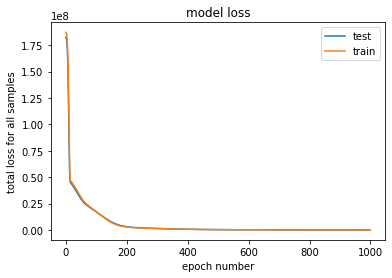

In [ ]:
# plot the training history
pyplot.plot(history.history['val_loss'], label='test')
pyplot.plot(history.history['loss'], label='train')
plt.title('model loss')
plt.xlabel('epoch number')
plt.ylabel('total loss for all samples')
pyplot.legend()
pyplot.show()

Test Set R-Square= 0.9997


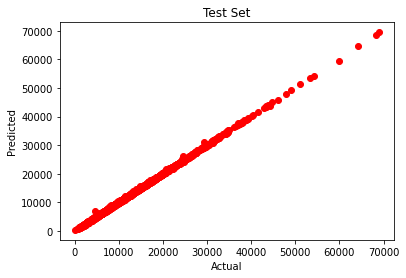

In [ ]:
# plot the predicted values vs the actual values 
test_results = numpy.genfromtxt("test_results.csv", delimiter=",")
plt.plot(Y_test,test_results,'ro')
plt.title('Test Set')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# compute R-Square value for test set
TestR2Value = r2_score(Y_test,test_results)
print("Test Set R-Square=", round(TestR2Value, 4))